<a href="https://colab.research.google.com/github/virf96/Proyectos/blob/master/Consideraciones_y_Modelo_autorregresivo_AR_Precios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Consideraciones para el ajuste de modelos predictivos con métodos autorregresivos para Series de Tiempo**

$\bullet$ Se debe ajustar bien a los datos (cuidar que no sobre ajuste)

$\bullet$ Debe tener buena capacidad para predecir datos futuros (Validar con alguna métrica o función de pérdida)

$\bullet$ Debe ser lo más simple posible

**Pasos a seguir para el ajuste**

$1.-$ Analizar la serie temporal y verificar que modelo se puede ajustar mejor.

$2.-$ Dividir datos en set de entrenamiento y prueba

$3.-$ Ajustar el modelo a los datos de entrenamiento

$4.-$ Evaluar el modelo en los datos de prueba

$5.-$ Re-ajustar el modelo con todos los datos

$6.-$ Predecir los datos futuros

**¿Cómo seleccionar el mejor modelo?**

Usualmente comenzamos con un modelos simple.

Ejemplo: $x_{t}=c+\phi_{1}x_{t-1}+\epsilon_{t}$ en este caso el periodo actual ($t_{1}$) no debería relacionarse con un periodo anterior ($t-1$).

Se puede llegara complejizar el modelo hasta el punto en el que tengamos $x_{t}=c+\phi_{1}x_{t-1}+...+\phi_{n}x_{t-n}+\epsilon_{t}$ en el que ya hemos introducido muchos retrasos.

**Nota:** Siempre debemos verificar que $\phi \neq 0$ es decir que los coeficientes $\phi$ estimados sean significativamente diferentes de cero, de lo contrario no aportarían nada.

Si el modelo se ajusta bien, se debe cumplir $\epsilon_{t}\sim WN(\mu,\sigma^{2})$, es decir que los residuos del modelo debe parecerse al ruido blanco.

**Criterios de selección de modelos**

**AIC:** Criterio de información akaike

(Evalua la colección de modelos realizados y estima la calidad de cada modelo en relación con los demás. 
**Penaliza a los modelos en base a su complejidad**, es decir al número de parámetros que tenga, va a preferir un modelo más simple que funciona a bien a otro que funciona solo un poco mejor y con más parámetros. )

**BIC:** Criterio de información bayesiana

(Este criterio es similar al AIC con la diferencia de que esta basado en métodos Bayesianos)

**Nota:** Se debe escoger el modelo que tenga criterios de información más bajos.

**Funciones de pérdida utilizadas**

MAD = $\frac{1}{T}\sum_{t=1}^{T} |\epsilon_{t}|$ 

(Mide la desviación absoluta de $\epsilon$, es decir de los errores del prónostico y los datos reales sobre periodos $T$ )

MSE = $\frac{1}{T}\sum_{t=1}^{T} \epsilon^{2}_{t}$ 

(Mide la desviación cuadrática de $\epsilon$, es decir de los errores del prónostico y los datos reales sobre periodos $T$ )

MAPE = $\frac{1}{T}\sum_{t=1}^{T} |\frac{\epsilon_{t}}{y_{t}}|$ 

(Mide la desviación porcentual de $\epsilon$, es decir de los errores del prónostico y los datos reales sobre periodos $T$ )








## **Modelo Autorregresivo AR**

A menudo encontramos similitudes entre valores pasados y valores presentes, esto se debe a que encontramos correlación entre dichos datos. La autocorrelación describe la relación de la variables consigo misma, esto nos va a permitir definir **un modelo AR que se basa solamente en valores de periodos pasados para predecir valores de periodos actuales**

Es un modelo lineal de la forma $x_{t}=c+\phi_{1} x_{t-1}+\epsilon_{t}$ es la suma de periodos pasados multiplicados por un coeficiente.

donde:

$c:$ es una constante.

$x_{t}:$ es el periodo actual.

$x_{t-1}:$ es un periodo anterior.

$\phi:$ es un coeficiente a estimar, donde $-1<\phi\leq 1$. 

$\epsilon_{t}:$ son los residuos, no es más que la diferencia entre la predicción para el periodo $t$ y el valor correcto . 

En el caso en el que nuestro problema sea descrito por un modelo **AR** de la forma $x_{t}=c+\phi_{1} x_{t-1}+\epsilon_{t}$ este es un modelo **AR(1)** en donde el orden del modelo indica el número de retrasos considerados para el modelo y es la forma más simple para este caso.

**¿Como determinamos cuantos retrasos?**

Para esto debemos de utilizar la función de auto correlación parcial, esta función nos va a permitir identificar las auto correlaciones entre diferentes periodos retrasados con respecto al presente.




## **Importing the relevant packages**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2
import statsmodels.tsa.stattools as sts 
import seaborn as sns
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Importing the Data and Pre-processing 

In [3]:
#Cargamos el df
raw_csv_data = pd.read_csv("https://raw.githubusercontent.com/virf96/curso-series-temporales/master/2.%20Serie%20temporal%20en%20R%20y%20Python/Python/Index2018.csv") 
#Copiamos el df en una nueva variable
df_comp=raw_csv_data.copy()
#Convertimos la variable "date" a formato fecha indicando que el formato de la variable empieza con el día
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
#Indexamos la variable "date" para una mejor visualización
df_comp.set_index("date", inplace=True)
#Indicamos la frecuencia de nuestros datos "business days"
df_comp=df_comp.asfreq('b')

In [4]:
df_comp.head()

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


In [5]:
#Verificamos que no haya na´s
df_comp.isna().sum()

spx       8
dax       8
ftse      8
nikkei    8
dtype: int64

In [6]:
#Rellenamos los na con el método front fill
df_comp=df_comp.fillna(method='ffill')

In [7]:
#Renombramos la variable "ftse" como "market value"
df_comp['market_value']=df_comp.ftse #ftse

In [8]:
#Borramos las variables que no utilizaremos
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']
#Indicamos el corte para guardar el set de entrenamiento y prueba
size = int(len(df_comp)*0.8)
#Guardamos el set de entrenamiento y validación con sus respectivos cortes
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

## The ACF

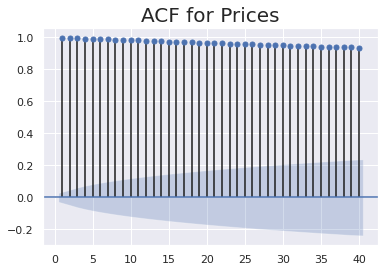

In [9]:
#Gráficamos la autocorrelación de market value sin tomar en cuenta el primer valor dado que no tendría sentido y con 40 retrasos
#Capturamos los efectos directos e indirectos del valor anterior sobre el valor presente 
#Podemos ver que los 40 retrasos son significativos al estar por encima del sombreado azul y además son positivos, esto podría indicar podriamos considerar los
#40 retrasos, esto haría un modelo bastante complejo por lo que antes se recomienda observar el gráfico de autocorrelación parcial 
sgt.plot_acf(df.market_value, zero = False, lags = 40)
plt.title("ACF for Prices", size = 20)
plt.show()

## The PACF

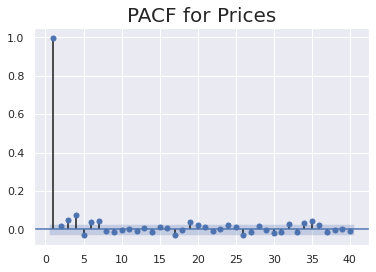

In [10]:
#Gráficamos la auto correlación parcial
#Observamos los efectos directos de los valores anteriores sobre el presente
#Los coeficientes son de diferentes tamaños, hay coeficientes significativos y no significativos
#A partir del retraso 25 los valores son muy cercanos a cero por lo que no los tomaremos en cuenta, su impacto sería minimo
#Observamos que el primer retraso es bastante significativo en comparación con los demás, así que empezaremos por ahí
sgt.plot_pacf(df.market_value, lags = 40, alpha = 0.05, zero = False, method = ('ols'))
plt.title("PACF for Prices", size = 20)
plt.show()

## The AR(1) Model

In [11]:
#Utilizamos la función ARMA en donde le pasamos la variable a ajustar y el orden del modelo
#El parametro order=(1,0) representa que solo incorporaremos 1 retraso en el modelo y cero representa que no consideramos ningún valor residual
model_ar = ARMA(df.market_value, order=(1,0))

In [12]:
#Ajustamos el modelo con .fit()
results_ar = model_ar.fit()

In [13]:
#Veamos las filas de la constante y el retraso seleccionado
#Observamos el coeficiente calculado
#El std.err que son los errores estandar, es decir que tan lejos en promedio esta nuestra estimación de los valores verdaderos
#z, es el valor del estadistico de prueba asociado para determinar la significación de cada una de las estimaciones
#La siguiente columna es el p-valor con lo cuál vemos que son muy significativos
#Y tenemos por último un intervalo de confianza, si el intervalo no contiene al cero decimos que es significativo, ejemplo entre .997 y 1 no esta el cero por lo cuál es significativo
results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(1, 0)   Log Likelihood              -27622.599
Method:                       css-mle   S.D. of innovations             59.258
Date:                Thu, 16 Jul 2020   AIC                          55251.198
Time:                        04:26:09   BIC                          55270.762
Sample:                    01-07-1994   HQIC                         55258.054
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5067.4707    486.503     10.416      0.000    4113.942    6021.000
ar.L1.market_value     0.9985      0.001   1298.545      0.000       0.997       1.000
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0015           +0.0000j            1.0015            0.0000
-----------------------------------------------------------------------------
"""

## Higher-Lag AR Models

In [14]:
#Veamos como funciona el modelo al añadirle un retraso, es decir AR(2)
model_ar_2 = ARMA(df.market_value, order=(2,0))
#Como al final vamos a comparar el modelo, guardamos el modeloen otra variable
results_ar_2 = model_ar_2.fit()
#Podemos observar que para un modelo AR(2), el segundo retraso ya nos es significativo
#Para el segundo retraso observamos que el intervalo de confianza entre .011 y .045 si contiene al cero
results_ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(2, 0)   Log Likelihood              -27621.871
Method:                       css-mle   S.D. of innovations             59.249
Date:                Thu, 16 Jul 2020   AIC                          55251.742
Time:                        04:26:11   BIC                          55277.827
Sample:                    01-07-1994   HQIC                         55260.883
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6411    495.670     10.268      0.000    4118.145    6061.137
ar.L1.market_value     0.9814      0.014     69.595      0.000       0.954       1.009
ar.L2.market_value     0.0171      0.014      1.211      0.226      -0.011       0.045
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0015           +0.0000j            1.0015            0.0000
AR.2          -58.4629           +0.0000j           58.4629            0.5000
-----------------------------------------------------------------------------
"""

In [ ]:
#Veamos ahora para un modelo AR(3)
model_ar_3 = ARMA(df.market_value, order=(3,0))
results_ar_3 = model_ar_3.fit()
#El segundo retraso no es significativo
results_ar_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(3, 0)   Log Likelihood              -27615.871
Method:                       css-mle   S.D. of innovations             59.178
Date:                Wed, 15 Jul 2020   AIC                          55241.742
Time:                        21:56:24   BIC                          55274.349
Sample:                    01-07-1994   HQIC                         55253.168
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6411    520.356      9.781      0.000    4069.761    6109.521
ar.L1.market_value     0.9806      0.014     69.619      0.000       0.953       1.008
ar.L2.market_value    -0.0309      0.020     -1.563      0.118      -0.070       0.008
ar.L3.market_value     0.0489      0.014      3.466      0.001       0.021       0.077
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0013           -0.0000j            1.0013           -0.0000
AR.2           -0.1850           -4.5161j            4.5199           -0.2565
AR.3           -0.1850           +4.5161j            4.5199            0.2565
-----------------------------------------------------------------------------
"""

In [ ]:
#Veamos para un AR(4)
model_ar_4 = ARMA(df.market_value, order=[4,0])
results_ar_4 = model_ar_4.fit()
#El 2ndo y 3er retraso no son significativos
results_ar_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(4, 0)   Log Likelihood              -27602.565
Method:                       css-mle   S.D. of innovations             59.022
Date:                Wed, 15 Jul 2020   AIC                          55217.130
Time:                        21:56:35   BIC                          55256.258
Sample:                    01-07-1994   HQIC                         55230.841
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6413    560.009      9.088      0.000    3992.043    6187.239
ar.L1.market_value     0.9770      0.014     69.492      0.000       0.949       1.005
ar.L2.market_value    -0.0286      0.020     -1.455      0.146      -0.067       0.010
ar.L3.market_value    -0.0224      0.020     -1.135      0.256      -0.061       0.016
ar.L4.market_value     0.0728      0.014      5.166      0.000       0.045       0.100
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0011           -0.0000j            1.0011           -0.0000
AR.2            0.9550           -2.0884j            2.2964           -0.1817
AR.3            0.9550           +2.0884j            2.2964            0.1817
AR.4           -2.6036           -0.0000j            2.6036           -0.5000
-----------------------------------------------------------------------------
"""

$\bullet$Otro dato importante en el resumen es **la probabilidad del logaritmo de la verosimilitud (Log Likelihood)** como regla general vamos a preferir el modelo que contenga un coeficiente más alto de Log likelihood.

$\bullet$Por otra parte hay que comparar los críterios de información **AIC** Y **BIC** recordando que nos va a interesar el modelo con menores coeficientes para estos criterios.

## Test de Contraste de logaritmo de verosimilitudes

Si $\alpha<.05$ ent, rechazamos $H_{0}$

$H_{0}:$ Los 2 modelos son significativamente similares

$H_{1}:$ Los 2 modelos son significativamente diferentes

In [29]:

#Le pasamos los 2 modelos y la diferencia entre la cantidad de parametros entre cada uno, por eso DF=1
#Con el método .llf hayamos las log verosimilitudes de ambos métodos
#El estadístico que hay que comporbar será 2 veces la diferencia entre la log verosimilitud del segundo modelo y el primero
#Después esto se compara con su distribución, la cuál es una chi2, le pasamos el valor del estadistivo y los grados de libertad o diferencia de parametros entre los modelos
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

## Comparing Higher-Lag AR Models

In [ ]:
#La aplicamos al modelo 2 y 3
#Aquí aceptamos que los 2 modelos son significativamente similares, en este caso lo recomendable es quedarnos con el modelo más simple
LLR_test(results_ar_2, results_ar_3)

0.001

In [ ]:
#La aplicamos al modelo 3 y 4
#Aquí aceptamos que los 2 modelos son significativamente similares, en este caso lo recomendable es quedarnos con el modelo más simple
LLR_test(results_ar_3, results_ar_4)

0.0

**Nota:** En el caso en el que se acepte que los modelos contrastados son diferentes, necesariamente el último retraso del modelo debe ser significativo para poderlo escoger sobre algún otro, si no es significativo tendríamos que descartar ese retraso y estaríamos en un modelo anterior.

In [ ]:
model_ar_4 = ARMA(df.market_value, order=[4,0])
results_ar_4 = model_ar_4.fit()
print(results_ar_4.summary()) 
print ("LLR test: " + str(LLR_test(results_ar_3, results_ar_4)))

                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(4, 0)   Log Likelihood              -27602.565
Method:                       css-mle   S.D. of innovations             59.022
Date:                Wed, 15 Jul 2020   AIC                          55217.130
Time:                        22:29:40   BIC                          55256.258
Sample:                    01-07-1994   HQIC                         55230.841
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6413    560.009      9.088      0.000    3992.043    6187.239
ar.L1.market_value     0.9770      0.014     69.492      0.000       0.949       1.005
ar.L2.market_value  

In [ ]:
#Modelo AR(5)
model_ar_5 = ARMA(df.market_value, order=(5,0))
#Ajustamos los valores
results_ar_5 = model_ar_5.fit()
#Resumen 
print(results_ar_5.summary())
#La prueba es significativa dado que 0.04<.05 y además el retraso 5 también es significativo, de momento nos quedamos con este modelo
print("\nLLR test p-value = " + str(LLR_test(results_ar_4, results_ar_5)))

                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(5, 0)   Log Likelihood              -27600.524
Method:                       css-mle   S.D. of innovations             58.997
Date:                Wed, 15 Jul 2020   AIC                          55215.049
Time:                        22:29:42   BIC                          55260.698
Sample:                    01-07-1994   HQIC                         55231.045
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5369.4922    703.058      7.637      0.000    3991.525    6747.460
ar.L1.market_value     0.9792      0.014     69.511      0.000       0.952       1.007
ar.L2.market_value  

In [ ]:
#Modelo AR(6)
model_ar_6 = ARMA(df.market_value, order=(6,0))
#Ajuste de los valores
results_ar_6 = model_ar_6.fit()
#Resumen
print(results_ar_6.summary())
#La prueba es significativa dado que 0.004<.04 y además el retraso 6 es significativo, nos quedamos ahora con el 6
print("\nLLR test p-value = " + str(LLR_test(results_ar_5, results_ar_6)))

                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(6, 0)   Log Likelihood              -27596.474
Method:                       css-mle   S.D. of innovations             58.950
Date:                Wed, 15 Jul 2020   AIC                          55208.947
Time:                        22:32:39   BIC                          55261.118
Sample:                    01-07-1994   HQIC                         55227.229
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6411    565.235      9.004      0.000    3981.802    6197.480
ar.L1.market_value     0.9803      0.014     69.604      0.000       0.953       1.008
ar.L2.market_value  

In [ ]:
#Modelo AR(7)
model_ar_7 = ARMA(df.market_value, order=(7,0))
#Ajustamos el modelo
results_ar_7 = model_ar_7.fit()
#Resumen del modelo
print(results_ar_7.summary())
#La prueba es significativa dado que 0.002<.004 y además el retraso 7 es significativo por lo que nos quedamos con el 7
print("\nLLR test p-value = " + str(LLR_test(results_ar_6, results_ar_7)))

                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(7, 0)   Log Likelihood              -27591.900
Method:                       css-mle   S.D. of innovations             58.896
Date:                Wed, 15 Jul 2020   AIC                          55201.799
Time:                        22:32:43   BIC                          55260.492
Sample:                    01-07-1994   HQIC                         55222.366
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6414    589.596      8.632      0.000    3934.054    6245.229
ar.L1.market_value     0.9786      0.014     69.518      0.000       0.951       1.006
ar.L2.market_value  

In [ ]:
#Modelo AR(8)
model_ar_8 = ARMA(df.market_value, order=(8,0))
#Ajustamos valores
results_ar_8 = model_ar_8.fit()
#Resumen del modelo
print(results_ar_8.summary())
#El coeficiente del retraso 8 no es significativo y además la prueba tampoco es significativa es decir .002<.5 por lo cuál nos quedamos con el 7
print("\nLLR test p-value = " + str(LLR_test(results_ar_7, results_ar_8)))

                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(8, 0)   Log Likelihood              -27591.739
Method:                       css-mle   S.D. of innovations             58.894
Date:                Wed, 15 Jul 2020   AIC                          55203.478
Time:                        22:39:57   BIC                          55268.692
Sample:                    01-07-1994   HQIC                         55226.329
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6413    585.021      8.700      0.000    3943.022    6236.260
ar.L1.market_value     0.9790      0.014     69.476      0.000       0.951       1.007
ar.L2.market_value  

In [ ]:
#Ahor vamos a comparar los 2 modelos ganadores que es el modelo con 1 retraso y con 7 retrasos
#La prueba es significativa por lo que rechazamos la hipotesis nula y nos quedamos con el modelo AR(7) dado que son significativamente diferentes
print("LLR test: " + str(LLR_test(results_ar, results_ar_7, DF = 6)))

LLR test: 0.0


Realizaremos un prueba de Dicky Fuller para comprobar que proviene de un proceso estacionario.

Recordemos que si $\lambda_{0}<\lambda_{crit} \Rightarrow$ Rechazamos que la serie sea estacionaria 

In [ ]:
#Ahora verifiquemos que la serie provenga de un proceso estacionario, dado que los modelos autorregresivos no funcionan bien con procesos no estacionarios.

#Utilizamos el método "adfuller"
#El primer valor es el valor del estadístico
#El valor crítico será arrojado para el 99%,90% y 95%
#El p-value es el segundo valor arrojado
#El 3er valor es el número de retrasos

#Observamos que el estadistico siempre es mayor que los lambda criticos independentemente de que intervalo de confianza tomemos por lo cuál la serie no es estacionaria
sts.adfuller(df.market_value)

(-1.9041551418836864,
 0.33010893277028336,
 6,
 5014,
 {'1%': -3.4316548765428174,
  '10%': -2.5670769326348926,
  '5%': -2.8621166146845334},
 54854.15304507557)

**Observación**
Podemos observar que a pesar que la prueba de log verosimilitudes nos hizo incinarnos por el modelo **AR(7)**, este modelo aún tiene retrasos que no son significativos y eso es un problema. Esto se debe a que los modelos autorregresivos no funcionan bien con series no estacionarias, este es un principal supuesto de los modelos autorresgresivos.

Una solución sería transformar los datos para que cumplan esta propiedad.

## Analysing the Residuals

In [ ]:
#Extraemos los residuos del modelo con el método .resid
df['res_price'] = results_ar_7.resid

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#Si el modelo AR(7) es el mejor predictor, entonces los residuos deben distribuirse como ruido blanco es decir media y varianza constantes
#La prueba de Dicky Fuller nos ayudara a verificar que los residuos sean estacionarios
#Aceptamos que son estacionarios
sts.adfuller(df.res_price)

(-76.07470446119133,
 0.0,
 0,
 5020,
 {'1%': -3.431653316130827,
  '10%': -2.5670765656497516,
  '5%': -2.8621159253018247},
 54842.4151490114)

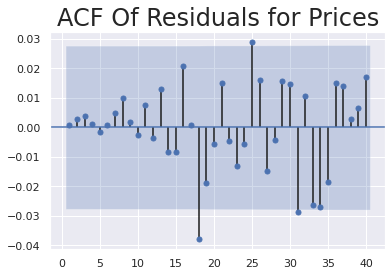

In [ ]:
#Además de que para el ruido blanco no debemos tener autocorrelación, en este caso en los residuos
#La mayoría cae dentro del sombreado azul por lo cuál no son significativos es decir no esta autocorrelacionados
#Al observar que algunos retrasos son significativos el gráfico sugiere que probablemente hay un mejor predictor
sgt.plot_acf(df.res_price, zero = False, lags = 40)
plt.title("ACF Of Residuals for Prices",size=24)
plt.show()

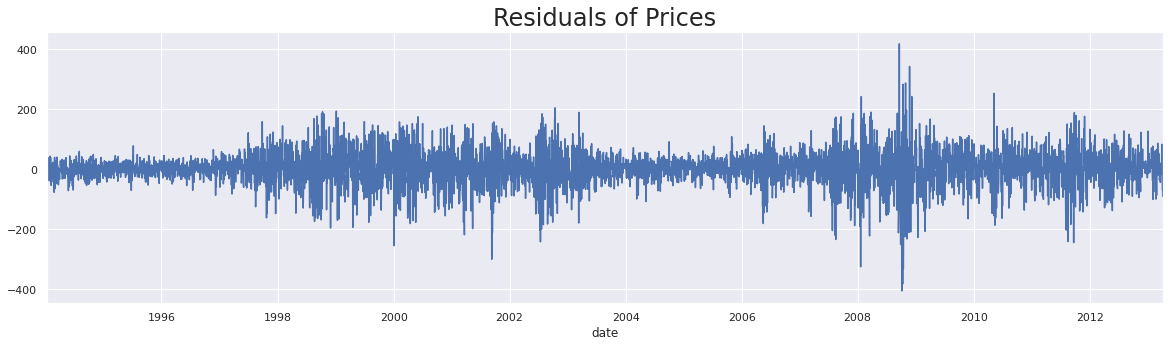

In [ ]:
#Veamos un gráfico de los residuos 
#La gráfica se asemeja a ruido blanco es decir no hay ningún patrón
df.res_price[1:].plot(figsize=(20,5))
plt.title("Residuals of Prices",size=24)
plt.show()

## Veamos con resolver el problema de la estacionalidad

In [43]:
#Copiamos el df en una nueva variable
df_comp=raw_csv_data.copy()
#Convertimos la variable "date" a formato fecha indicando que el formato de la variable empieza con el día
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
#Indexamos la variable "date" para una mejor visualización
df_comp.set_index("date", inplace=True)
#Indicamos la frecuencia de nuestros datos "business days"
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')
df_comp['market_value']=df_comp.ftse
#Borramos las variables que no utilizaremos
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']
#Indicamos el corte para guardar el set de entrenamiento y prueba
size = int(len(df_comp)*0.8)
#Guardamos el set de entrenamiento y validación con sus respectivos cortes
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

In [44]:
df_comp.head()

,market_value
date,
1994-01-07,3445.98
1994-01-10,3440.58
1994-01-11,3413.77
1994-01-12,3372.02
1994-01-13,3360.01


## **Utilizaremos los retornos de la variable**

In [15]:
#Realizamos la transformación retorno, es decir ahora la variable será un porcentaje de cambio entre los valores para periodos consecutivos
#Ejemplo, si los datos son diarios el retorno será el porcentaje de cambio de un día para otro
#Utilizamos el método "pct_change" para extraer la tasa de cambio entre un periodo y otro, además la multiplicamos por 100 para obtener el porcentaje
df['returns']=df.market_value.pct_change(1).mul(100)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [16]:
df.head()

,market_value,returns
date,,
1994-01-07,3445.98,NaN
1994-01-10,3440.58,-0.156704
1994-01-11,3413.77,-0.779229
1994-01-12,3372.02,-1.222988
1994-01-13,3360.01,-0.356166


In [17]:
#Para poder hacer el contraste de hipotesis vamos a eliminar la primera fila
df=df.iloc[1:]

In [18]:
df.head()

,market_value,returns
date,,
1994-01-10,3440.58,-0.156704
1994-01-11,3413.77,-0.779229
1994-01-12,3372.02,-1.222988
1994-01-13,3360.01,-0.356166
1994-01-14,3400.56,1.206842


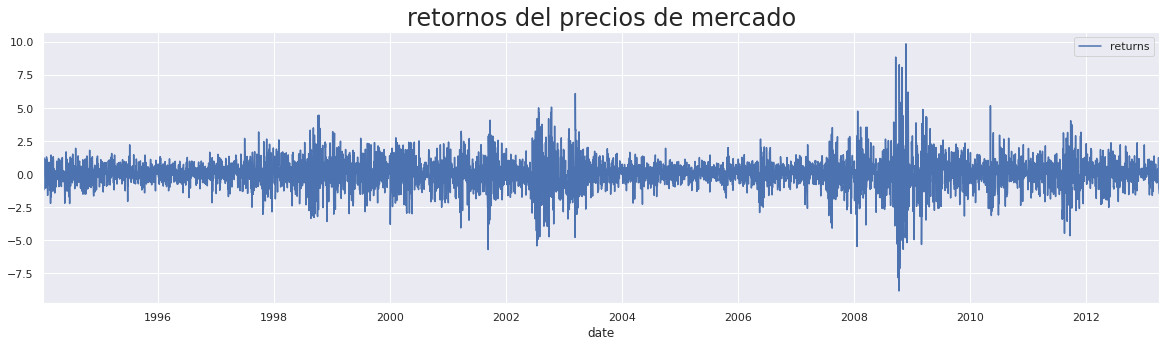

In [26]:
#Veamos su gráfico
#Podemos ver un comportamiento estacionario
df.returns.plot(figsize = (20,5))
plt.title("retornos del precios de mercado", size = 24)
plt.legend() 
plt.show()

In [19]:
#Ahora verificamos que sea estacionaria
#Veamos ahora el segundo valor que el p-value en este caso es menor que .05 por lo que aceptamos que la serie sea estacionaria
sts.adfuller(df.returns)

(-12.770265719497182,
 7.798058336040345e-24,
 32,
 4987,
 {'1%': -3.431661944885779,
  '10%': -2.5670785949998973,
  '5%': -2.8621197374408225},
 15696.7672456975)

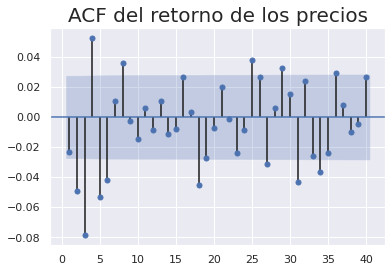

In [20]:
#Ahora veamos los gráficos de autocorrelación y autocorrelación parcial
sgt.plot_acf(df.returns, zero = False, lags = 40)
plt.title("ACF del retorno de los precios", size = 20)
plt.show()

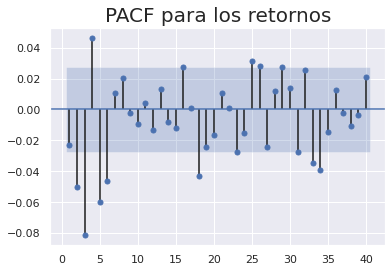

In [23]:
sgt.plot_pacf(df.returns, lags = 40, alpha = 0.05, zero = False, method = ('ols'))
plt.title("PACF para los retornos", size = 20)
plt.show()

In [34]:
#Modelo AR(1) 
model_ar_1 = ARMA(df.returns, order=(1,0))
#Ajustamos los valores
results_ar_1 = model_ar_1.fit()
#Podemos observar que el primer retraso no es significativo
print(results_ar_1.summary())


                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(1, 0)   Log Likelihood               -7929.749
Method:                       css-mle   S.D. of innovations              1.174
Date:                Thu, 16 Jul 2020   AIC                          15865.497
Time:                        04:35:30   BIC                          15885.061
Sample:                    01-10-1994   HQIC                         15872.353
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.016      1.159      0.247      -0.013       0.051
ar.L1.returns    -0.0230      0.014     -1.631      0.103      -0.051       0.005
                                    Root

In [35]:
#Modelo AR(2)
model_ar_2 = ARMA(df.returns, order=(2,0))
#Ajustamos los valores
results_ar_2 = model_ar_2.fit()
#Resumen 
print(results_ar_2.summary())
#La prueba es significativa, además de ue el segundo retraso es significativo por el momento nos quedamos con este modelo
print("\nLLR test p-value = " + str(LLR_test(results_ar_1, results_ar_2)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(2, 0)   Log Likelihood               -7923.456
Method:                       css-mle   S.D. of innovations              1.173
Date:                Thu, 16 Jul 2020   AIC                          15854.911
Time:                        04:35:33   BIC                          15880.996
Sample:                    01-10-1994   HQIC                         15864.052
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.015      1.220      0.222      -0.011       0.049
ar.L1.returns    -0.0242      0.014     -1.716      0.086      -0.052       0.003
ar.L2.returns    -0.0500      0.014     

In [36]:
#Modelos AR(3)
model_ar_3 = ARMA(df.returns, order=(3,0))
#Ajustamos los valores
results_ar_3 = model_ar_3.fit()
#Resumen 
print(results_ar_3.summary())
#La prueba es significativa dado que 0.00<.05 y además el retraso 3 también es significativo, de momento nos quedamos con este modelo
print("\nLLR test p-value = " + str(LLR_test(results_ar_2, results_ar_3)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(3, 0)   Log Likelihood               -7906.738
Method:                       css-mle   S.D. of innovations              1.169
Date:                Thu, 16 Jul 2020   AIC                          15823.477
Time:                        04:35:46   BIC                          15856.083
Sample:                    01-10-1994   HQIC                         15834.902
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.330      0.184      -0.009       0.047
ar.L1.returns    -0.0283      0.014     -2.011      0.044      -0.056      -0.001
ar.L2.returns    -0.0521      0.014     

In [37]:
#Modelo AR(4)
model_ar_4 = ARMA(df.returns, order=(4,0))
#Ajustamos los valores
results_ar_4 = model_ar_4.fit()
#Resumen 
print(results_ar_4.summary())
#La prueba es significativa dado que 0.01<.05 y además el retraso 4 también es significativo, de momento nos quedamos con este modelo
print("\nLLR test p-value = " + str(LLR_test(results_ar_3, results_ar_4)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(4, 0)   Log Likelihood               -7901.330
Method:                       css-mle   S.D. of innovations              1.168
Date:                Thu, 16 Jul 2020   AIC                          15814.661
Time:                        04:36:03   BIC                          15853.788
Sample:                    01-10-1994   HQIC                         15828.371
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.015      1.267      0.205      -0.010       0.048
ar.L1.returns    -0.0245      0.014     -1.739      0.082      -0.052       0.003
ar.L2.returns    -0.0496      0.014     

In [38]:
#Modelo AR(5)
model_ar_5 = ARMA(df.returns, order=(5,0))
#Ajustamos los valores
results_ar_5 = model_ar_5.fit()
#Resumen 
print(results_ar_5.summary())
#La prueba es significativa dado que 0.00<0.05 además el retraso 5 es significativo, nos quedamos con este modelo 
print("\nLLR test p-value = " + str(LLR_test(results_ar_4, results_ar_5)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(5, 0)   Log Likelihood               -7892.390
Method:                       css-mle   S.D. of innovations              1.166
Date:                Thu, 16 Jul 2020   AIC                          15798.779
Time:                        04:36:15   BIC                          15844.428
Sample:                    01-10-1994   HQIC                         15814.775
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.348      0.178      -0.009       0.046
ar.L1.returns    -0.0217      0.014     -1.544      0.123      -0.049       0.006
ar.L2.returns    -0.0544      0.014     

In [39]:
#Modelos AR(6)
model_ar_6 = ARMA(df.returns, order=(6,0))
#Ajustamos los valores
results_ar_6 = model_ar_6.fit()
#Resumen 
print(results_ar_6.summary())
#La prueba es significativa 0.001<0.05, además de que el retraso 6 es significativo
print("\nLLR test p-value = " + str(LLR_test(results_ar_5, results_ar_6)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(6, 0)   Log Likelihood               -7886.945
Method:                       css-mle   S.D. of innovations              1.164
Date:                Thu, 16 Jul 2020   AIC                          15789.890
Time:                        04:36:26   BIC                          15842.059
Sample:                    01-10-1994   HQIC                         15808.170
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.414      0.157      -0.007       0.045
ar.L1.returns    -0.0245      0.014     -1.740      0.082      -0.052       0.003
ar.L2.returns    -0.0523      0.014     

In [40]:
#Modelo AR(7)
model_ar_7 = ARMA(df.returns, order=(7,0))
#Ajustamos los valores
results_ar_7 = model_ar_7.fit()
#Resumen 
print(results_ar_7.summary())
#La prueba no es significativa 0.44>0.05y el retraso 7 no es significativo 
print("\nLLR test p-value = " + str(LLR_test(results_ar_6, results_ar_7)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(7, 0)   Log Likelihood               -7886.647
Method:                       css-mle   S.D. of innovations              1.164
Date:                Thu, 16 Jul 2020   AIC                          15791.294
Time:                        04:36:39   BIC                          15849.985
Sample:                    01-10-1994   HQIC                         15811.860
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.399      0.162      -0.008       0.045
ar.L1.returns    -0.0240      0.014     -1.702      0.089      -0.052       0.004
ar.L2.returns    -0.0517      0.014     

In [41]:
#Modelo AR(8)
model_ar_8 = ARMA(df.returns, order=(8,0))
#Ajustamos los valores
results_ar_8 = model_ar_8.fit()
#Resumen 
print(results_ar_8.summary())
#La prueba no es significativa 0.148>0.05 y el retraso 8 tampoco es significativo
print("\nLLR test p-value = " + str(LLR_test(results_ar_7, results_ar_8)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(8, 0)   Log Likelihood               -7885.599
Method:                       css-mle   S.D. of innovations              1.164
Date:                Thu, 16 Jul 2020   AIC                          15791.199
Time:                        04:36:54   BIC                          15856.410
Sample:                    01-10-1994   HQIC                         15814.050
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.370      0.171      -0.008       0.046
ar.L1.returns    -0.0242      0.014     -1.718      0.086      -0.052       0.003
ar.L2.returns    -0.0507      0.014     

In [42]:
#Para este punto los modelos ganadores son AR(2) por ser el modelo más simple y AR(6) por ser el modelo con mejores resultados
#haremos una prueba de log verosimilitudes para ver con cuál quedarnos
#La prueba es significativa por lo que rechazamos la hipotesis nula y nos quedamos con el modelo AR(6) dado que son significativamente diferentes
print("LLR test: " + str(LLR_test(results_ar_2, results_ar_6, DF = 4)))


LLR test: 0.0


In [66]:
#Extraemos los residuos del modelo con el método .resid
df['res_returns'] = results_ar_6.resid

In [67]:
df.head()

,market_value,returns,res_returns
date,,,
1994-01-10,3440.58,-0.156704,-0.175623
1994-01-11,3413.77,-0.779229,-0.802198
1994-01-12,3372.02,-1.222988,-1.270028
1994-01-13,3360.01,-0.356166,-0.466065
1994-01-14,3400.56,1.206842,1.061277


In [68]:
#Si el modelo AR(6) es el mejor predictor, entonces los residuos deben distribuirse como ruido blanco es decir media y varianza constantes
#La prueba de Dicky Fuller nos ayudara a verificar que los residuos sean estacionarios
#Aceptamos que son estacionarios
sts.adfuller(df.res_returns)

(-70.78380171410286,
 0.0,
 0,
 5019,
 {'1%': -3.4316535759402753,
  '10%': -2.567076626752987,
  '5%': -2.8621160400844468},
 15692.570834395005)

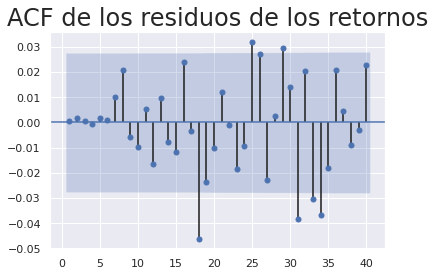

In [69]:
#Además de que para el ruido blanco no debemos tener autocorrelación, en este caso en los residuos
#La mayoría cae dentro del sombreado azul por lo cuál no son significativos es decir no esta autocorrelacionados
#Al observar que algunos retrasos son significativos el gráfico sugiere que probablemente hay un mejor predictor
sgt.plot_acf(df.res_returns, zero = False, lags = 40)
plt.title("ACF de los residuos de los retornos",size=24)
plt.show()

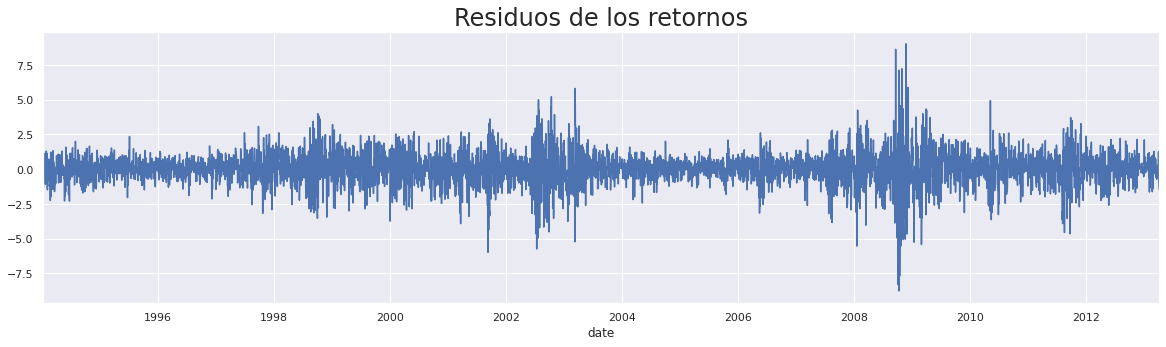

In [49]:
#Veamos un gráfico de los residuos 
#La gráfica se asemeja a ruido blanco es decir no hay ningún patrón
df.res_returns[1:].plot(figsize=(20,5))
plt.title("Residuos de los retornos",size=24)
plt.show()